In [41]:
# Spotify Mood Timeline: Step-by-Step Code (Jupyter Notebook)

import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sys
sys.path.append('./src')


print("All libraries imported successfully.")


All libraries imported successfully.


In [42]:
# Spotify Mood Timeline: Step-by-Step Code (Jupyter Notebook)

import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# 📌 STEP 2: Spotify API Authentication
# Replace with your credentials from Spotify Developer Dashboard

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id="98cdc211a6cb4dd58f15da961398486f",
    client_secret="ac336b8778384760bcb40ba6b344e39c",
    redirect_uri="http://127.0.0.1:8888/callback",  # ✅ local redirect for Jupyter
    scope="user-read-recently-played",
    show_dialog=True,        # ✅ force new login every time
    cache_path=".cache"      # ✅ avoid stale/invalid token
))




try:
    user = sp.current_user()
    print(f"✅ Authenticated as: {user['display_name']}")
except Exception as e:
    print("❌ Authentication failed:", e)


✅ Authenticated as: G.Prathima


In [43]:
# 📥 STEP 3: Fetch Recently Played Tracks
def get_recent_tracks(limit=50):
    results = sp.current_user_recently_played(limit=limit)
    return results['items']

recent_tracks = get_recent_tracks()

print(f"🎧 Fetched {len(recent_tracks)} recent tracks.")
print("Example track:", recent_tracks[0]['track']['name'], "by", recent_tracks[0]['track']['artists'][0]['name'])


🎧 Fetched 50 recent tracks.
Example track: Perfect by Ed Sheeran


In [44]:
import pandas as pd
import os

# Create DataFrame from recent tracks
df = pd.DataFrame([{
    'name': item['track']['name'],
    'artist': item['track']['artists'][0]['name'],
    'played_at': item['played_at']
} for item in recent_tracks])

# Make sure the data directory exists
os.makedirs('./data', exist_ok=True)

# Save DataFrame to CSV
df.to_csv('./data/cleaned.csv', index=False)

print("✅ Saved recent tracks to './data/cleaned.csv'")


✅ Saved recent tracks to './data/cleaned.csv'


In [45]:
try:
    me = sp.current_user()
    print("✅ Authenticated as:", me['display_name'])
except Exception as e:
    print("❌ Authentication failed:", e)


✅ Authenticated as: G.Prathima


In [46]:
import requests
import urllib.parse
import time
import json
import os
import pandas as pd
import sys

# Ensure 'utils' is in sys.path for local imports
utils_path = os.path.abspath(os.path.join(os.getcwd(), "utils"))
if utils_path not in sys.path and os.path.isdir(utils_path):
    sys.path.append(utils_path)

from src.utils.step_2 import load_cleaned_data

# Load step_2 DataFrame
df = load_cleaned_data()

# Initialize or load feature cache
cache_path = "features_cache.json"
if os.path.exists(cache_path):
    with open(cache_path, "r") as f:
        features_cache = json.load(f)
else:
    features_cache = {}

# Deduplicated list
original_tracks = [
    {
        "index": idx + 1,
        "name": row["name"],
        "artist": row["artist"],
        "played_at": row["played_at"]
    }
    for idx, row in df.iterrows()
]

unique_songs = {}
for track in original_tracks:
    key = (track["name"].lower(), track["artist"].lower())
    if key not in unique_songs:
        unique_songs[key] = track

# ------------------------ Feature Extractors ------------------------ #

def get_features_acousticbrainz(name, artist):
    try:
        query = f"{name} {artist}".replace(" ", "+")
        url = f"https://musicbrainz.org/ws/2/recording/?query={query}&fmt=json&limit=1"
        res = requests.get(url).json()
        if 'recordings' not in res or not res['recordings']:
            return None
        mbid = res['recordings'][0]['id']
        ab_url = f"https://acousticbrainz.org/api/v1/{mbid}/low-level"
        ab_data = requests.get(ab_url).json()
        return {
            'valence': ab_data.get('tonal', {}).get('chords_strength'),
            'energy': ab_data.get('lowlevel', {}).get('spectral_complexity'),
            'danceability': ab_data.get('rhythm', {}).get('beats_count'),
            'tempo': ab_data.get('rhythm', {}).get('bpm')
        }
    except:
        return None

def get_features_lastfm(name, artist):
    try:
        api_key = "YOUR_LASTFM_API_KEY"
        url = f"http://ws.audioscrobbler.com/2.0/?method=track.getInfo&api_key={api_key}&artist={urllib.parse.quote(artist)}&track={urllib.parse.quote(name)}&format=json"
        data = requests.get(url).json()
        tags = data.get('track', {}).get('toptags', {}).get('tag', [])
        tag_names = [t['name'].lower() for t in tags]
        return {
            'valence': 0.9 if 'happy' in tag_names else 0.2 if 'sad' in tag_names else None,
            'energy': 0.8 if 'energetic' in tag_names else 0.3 if 'calm' in tag_names else None,
            'danceability': 0.7 if 'dance' in tag_names else 0.3,
            'tempo': None
        }
    except:
        return None

def get_features_theaudiodb(name, artist):
    try:
        url = f"https://www.theaudiodb.com/api/v1/json/2/searchtrack.php?s={urllib.parse.quote(artist)}&t={urllib.parse.quote(name)}"
        data = requests.get(url).json()
        track = data.get("track", [None])[0]
        if not track:
            return None
        return {
            'valence': 0.6,
            'energy': float(track.get("intScore", 5)) / 10 if track.get("intScore") else None,
            'danceability': None,
            'tempo': float(track.get("intTempo")) if track.get("intTempo") else None
        }
    except:
        return None

def get_features_audd(name, artist):
    try:
        # Placeholder: AUDD does not provide direct features
        return None
    except:
        return None

def get_features_chartmetric(name, artist):
    try:
        # Placeholder: Paid API
        return None
    except:
        return None

# ------------------------ Main Loop ------------------------ #

features_map = {}
for i, ((name, artist), track_info) in enumerate(unique_songs.items(), start=1):
    key_str = f"{name.lower()}|||{artist.lower()}"

    if key_str in features_cache:
        features = features_cache[key_str]
        print(f"♻️ [{i}] Loaded from cache: {track_info['name']} by {track_info['artist']}")
    else:
        print(f"🎯 [{i}] Trying features for: {track_info['name']} by {track_info['artist']}")
        for source in [
            get_features_acousticbrainz,
            get_features_lastfm,
            get_features_theaudiodb,
            get_features_audd,
            get_features_chartmetric
        ]:
            features = source(name, artist)
            if features and any(v is not None for v in features.values()):
                features_cache[key_str] = features
                print(f"✅ Got features from {source.__name__}")
                break
            else:
                print(f"❌ {source.__name__} failed.")
        else:
            print(f"⚠️ All sources failed for: {name} by {artist}")
            features = {}

        time.sleep(1.5)  # polite pause for API

    features_map[(name.lower(), artist.lower())] = features

# Apply features to all 50 tracks (with duplication backfill)
for track in original_tracks:
    key = (track["name"].lower(), track["artist"].lower())
    features = features_map.get(key, {})
    track.update(features)

# Save updated cache
with open(cache_path, "w") as f:
    json.dump(features_cache, f, indent=2)

# Final DataFrame
df_final = pd.DataFrame(original_tracks)
print("\n📊 Final DataFrame Preview:")
print(df_final.head())


♻️ [1] Loaded from cache: Perfect by Ed Sheeran
♻️ [2] Loaded from cache: Woke Up by Sheff G
♻️ [3] Loaded from cache: Tu Hain Toh (From "Mr. And Mrs. Mahi") by Bunny
♻️ [4] Loaded from cache: O Shera - Teer Te Taj (Film Version) - From "Kesari Chapter 2" by Shashwat Sachdev
♻️ [5] Loaded from cache: Zamaana Lage (From "Metro ... In Dino") by Pritam
♻️ [6] Loaded from cache: AANKH by Sunidhi Chauhan
♻️ [7] Loaded from cache: Godari Gattu Meedha (From "Sankranthiki Vasthunam") by Ramana Gogula
♻️ [8] Loaded from cache: Dabidi Dibidi (From "Daaku Maharaaj") by Thaman S
♻️ [9] Loaded from cache: Prema Velluva (From "Hit - 3") (Telugu) by Mickey J. Meyer
♻️ [10] Loaded from cache: Ecstasy by Ritvik Virmani
♻️ [11] Loaded from cache: Polytope by Daichi Miura
♻️ [12] Loaded from cache: Your Number by Darkoo
♻️ [13] Loaded from cache: On My Mind by Alex Warren
♻️ [14] Loaded from cache: All I Want by Kodaline
♻️ [15] Loaded from cache: Ordinary by Alex Warren
♻️ [16] Loaded from cache: Madhur

In [47]:
# Use df_final to create plot_df as in cell 7
plot_df = df_final.dropna(subset=['valence']).copy()

# 🛠️ Ensure 'played_at' is in correct string or datetime format
if isinstance(plot_df['played_at'].iloc[0], dict):
    plot_df['played_at'] = plot_df['played_at'].apply(lambda x: x.get('played_at') if isinstance(x, dict) else x)

# Convert to datetime format if needed
plot_df['played_at'] = pd.to_datetime(plot_df['played_at'], errors='coerce')


C:\Users\ACER\AppData\Local\Temp\ipykernel_32496\814987614.py:31: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ACER\OneDrive\Documents\spotify mood timeline\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


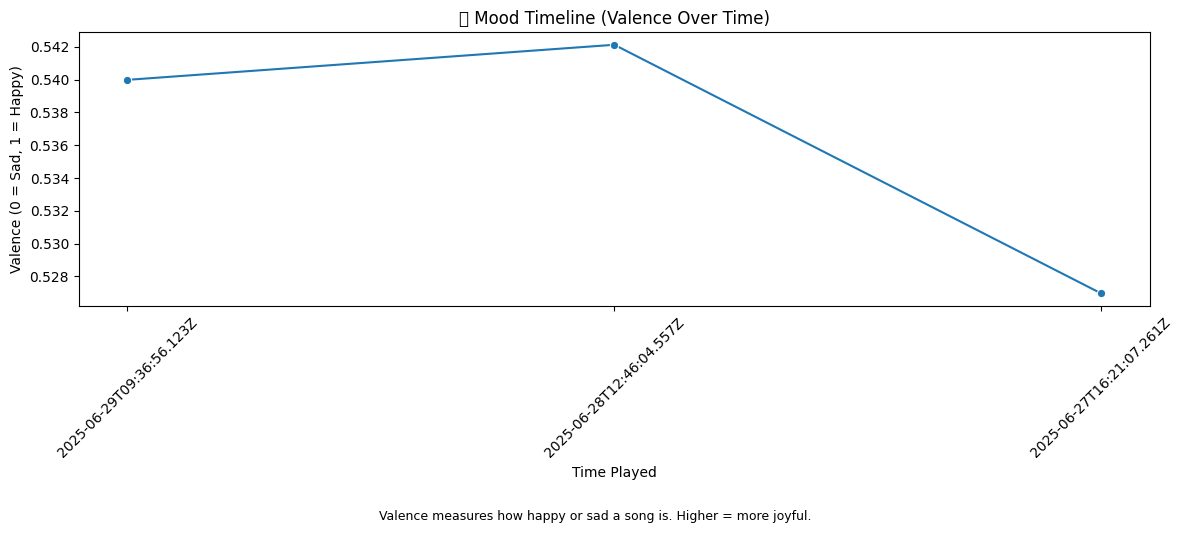

In [48]:
# ...existing code...

# 📈 STEP 5: Plot Valence Timeline
# Use df_final and drop rows where 'valence' is missing
plot_df = df_final.dropna(subset=['valence']).copy()

# Extract a numeric value from the valence dict (e.g., 'mean' or 'dmean')
def extract_valence(v):
	if isinstance(v, dict):
		# Try 'mean', fallback to 'dmean', fallback to first float value
		for key in ['mean', 'dmean']:
			if key in v and isinstance(v[key], (float, int)):
				return v[key]
		# fallback: return first float value in dict
		for val in v.values():
			if isinstance(val, (float, int)):
				return val
		return None
	elif isinstance(v, (float, int)):
		return v
	return None

plot_df['valence_num'] = plot_df['valence'].apply(extract_valence)

plt.figure(figsize=(12, 5))
sns.lineplot(x='played_at', y='valence_num', data=plot_df, marker='o')
plt.title('🎵 Mood Timeline (Valence Over Time)')
plt.xlabel('Time Played')
plt.ylabel('Valence (0 = Sad, 1 = Happy)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.figtext(0.5, -0.05, "Valence measures how happy or sad a song is. Higher = more joyful.", ha="center", fontsize=9)
plt.show()
# ...existing code...

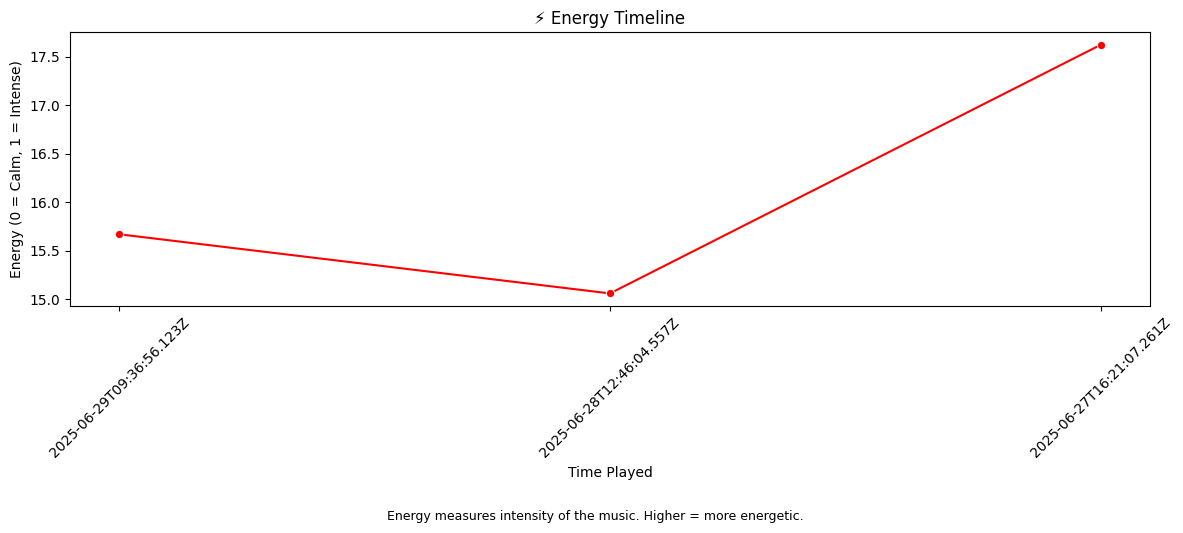

In [34]:
# 📈 STEP 6: Energy Timeline

# Extract a numeric value from the energy dict (e.g., 'mean' or 'dmean')
def extract_energy(e):
	if isinstance(e, dict):
		# Try 'mean', fallback to 'dmean', fallback to first float value
		for key in ['mean', 'dmean']:
			if key in e and isinstance(e[key], (float, int)):
				return e[key]
		for val in e.values():
			if isinstance(val, (float, int)):
				return val
		return None
	elif isinstance(e, (float, int)):
		return e
	return None

plot_df['energy_num'] = plot_df['energy'].apply(extract_energy)

plt.figure(figsize=(12, 5))
sns.lineplot(x='played_at', y='energy_num', data=plot_df, marker='o', color='red')
plt.title('⚡ Energy Timeline')
plt.xlabel('Time Played')
plt.ylabel('Energy (0 = Calm, 1 = Intense)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.figtext(0.5, -0.05, "Energy measures intensity of the music. Higher = more energetic.", ha="center", fontsize=9)
plt.show()

C:\Users\ACER\AppData\Local\Temp\ipykernel_32496\2826912016.py:9: UserWarning: Glyph 128131 (\N{DANCER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ACER\OneDrive\Documents\spotify mood timeline\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128131 (\N{DANCER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


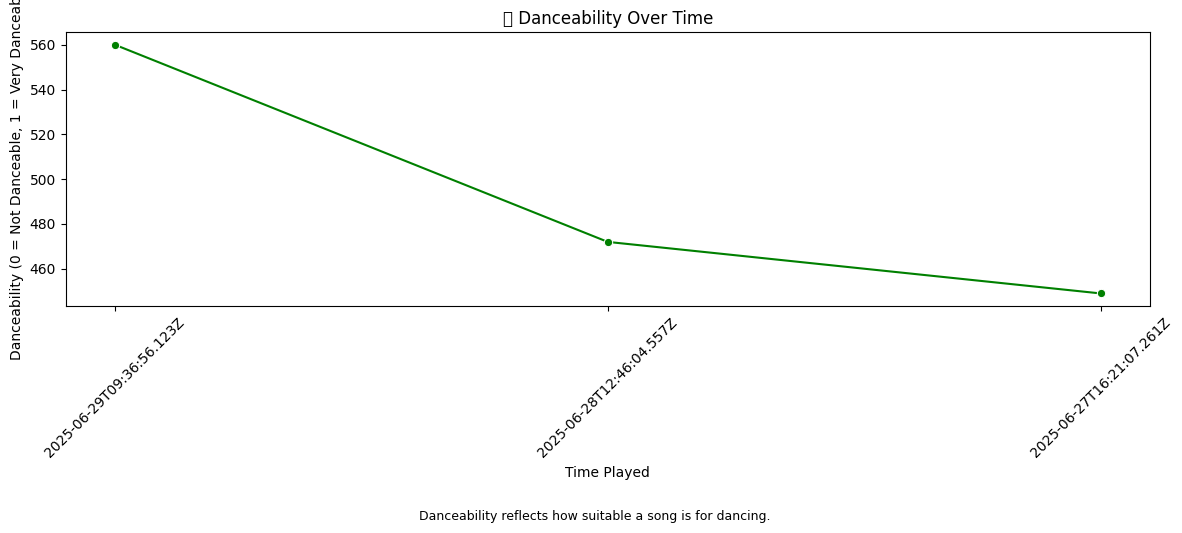

In [36]:
# 📈 STEP 7: Danceability Timeline

plt.figure(figsize=(12, 5))
sns.lineplot(x='played_at', y='danceability', data=plot_df, marker='o', color='green')
plt.title('💃 Danceability Over Time')
plt.xlabel('Time Played')
plt.ylabel('Danceability (0 = Not Danceable, 1 = Very Danceable)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.figtext(0.5, -0.05, "Danceability reflects how suitable a song is for dancing.", ha="center", fontsize=9)
plt.show()

In [38]:
# ✅ STEP 8: Summary Statistics
avg_valence = plot_df['valence_num'].mean()
avg_energy = plot_df['energy_num'].mean()

mood_summary = ""
if avg_valence < 0.3 and avg_energy < 0.4:
    mood_summary = "😔 Your recent music indicates a low mood. Try listening to uplifting songs."
elif avg_valence > 0.7:
    mood_summary = "😄 Your music mood is generally very positive! Keep it up."
else:
    mood_summary = "😌 Your music mood is balanced. You seem to enjoy a mix of emotions."

print("\n🧠 Mood Summary:")
print(mood_summary)


🧠 Mood Summary:
😌 Your music mood is balanced. You seem to enjoy a mix of emotions.
